# Max-Flow Algorithms: Project Overview and Guide

This notebook provides an empirical comparison of several classic maximum flow algorithms, implemented and benchmarked as part of this project. The algorithms included are:
- **Ford-Fulkerson (DFS and BFS/Edmonds-Karp variants)**
- **Edmonds-Karp (Ford-Fulkerson with BFS)**
- **Dinic's Algorithm**
- **Push-Relabel**
- **Boykov-Kolmogorov (BK)**

## Project Structure
- `algorithms/fordfulkerson/`: Ford-Fulkerson (DFS & BFS/Edmonds-Karp)
- `algorithms/dinics/`: Dinic's Algorithm
- `algorithms/push_relabel/`: Push-Relabel Algorithm
- `Boykov-Kolmogorov/`: BK Algorithm (image & grid)
- `main.ipynb`: This notebook for empirical comparison and visualization

## Algorithms Overview

**Ford-Fulkerson (DFS & BFS/Edmonds-Karp):**
- Classic augmenting path method for computing maximum flow.
- DFS variant is the original Ford-Fulkerson; BFS variant is known as Edmonds-Karp, which guarantees polynomial time.
- Implementation supports both methods via a `method` argument.
- Compatible with visualization and analysis tooling.

**Edmonds-Karp (BFS):**
- Special case of Ford-Fulkerson using BFS to find shortest augmenting paths.
- Ensures polynomial time complexity O(VE²).
- Included as a separate wrapper for clarity in comparison.

**Dinic's Algorithm:**
- Strongly polynomial algorithm using level graphs and blocking flows.
- Combines BFS (to build level graph) and DFS (to find blocking flows).
- Particularly efficient for bipartite and dense graphs.
- Features dead-end pruning for speed.

**Push-Relabel:**
- Maintains a preflow and locally pushes excess flow between vertices.
- Uses height labels and relabel operations to guide flow.
- FIFO selection heuristic for active vertices; achieves O(V³) time complexity.
- Good practical performance and supports min-cut extraction.

**Boykov-Kolmogorov (BK):**
- Designed for computer vision/image segmentation, but also supports synthetic grid graphs.
- Grows two trees from source and sink, augmenting flow when they meet.
- Empirically very efficient on grid-like and sparse graphs, despite pessimistic worst-case bounds.

## How to Use This Notebook
- All algorithms (including Ford-Fulkerson and Edmonds-Karp) are run on a shared set of graphs for fair comparison.
- BK is run on its own grid graphs (and can also be run on images).
- The notebook loads each algorithm, runs them on the datasets, and collects timing and flow results.
- Results are visualized as runtime vs. number of edges and vertices, both per-algorithm and in aggregate.

## Requirements
- Python 3.7+
- Install dependencies from each algorithm's `requirements.txt` (see README for details).

## Results & Visualization
- Plots show empirical runtime as a function of the number of edges and vertices for all algorithms.
- Results are saved in CSV files and visualized using matplotlib and seaborn.

## Notes
- Ford-Fulkerson supports both DFS and BFS (Edmonds-Karp) variants.
- All algorithms use a common graph file format for input (see code for details).
- For BK, both image and grid graph experiments are supported.

---
*For more details, see the README.md in the project root and each algorithm's folder.*

In [110]:
# Import required libraries
%matplotlib inline
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [126]:
# Utility to load graphs from a folder (shared for Ford-Fulkerson, Dinic, Push-Relabel)
def load_graph_from_file(filepath):
    """
    Assumes graph file format: first line m n, then m lines of u v c (0-based or 1-based, will auto-detect)
    Returns: n, edge_list (u, v, c)
    """
    with open(filepath, 'r') as f:
        lines = [line.strip() for line in f if line.strip() and not line.startswith('#')]
    m, n = map(int, lines[0].split())  # m = num_edges, n = num_vertices
    # n, m = map(int, lines[0].split())  # m = num_edges, n = num_vertices
    edge_list = []
    for line in lines[1:]:
        parts = line.split()
        if len(parts) < 3:
            continue
        u, v = map(int, parts[:2])
        c = float(parts[2])
        # Detect 1-based or 0-based
        if u == 0 or v == 0:
            edge_list.append((u, v, c))
        else:
            edge_list.append((u-1, v-1, c))
    return m, n, edge_list

In [127]:
# Import algorithm implementations
import importlib.util

def import_from_path(module_name, file_path):
    spec = importlib.util.spec_from_file_location(module_name, file_path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module

# Ford-Fulkerson (fordfulkerson)
fordfulkerson_mod = import_from_path('fordfulkerson', './algorithms/fordfulkerson/code/ff.py')  # Update path if needed
# Dinic's
dinic_mod = import_from_path('dinics', './algorithms/dinics/code/dinics.py')
# Push-Relabel
push_relabel_mod = import_from_path('push_relabel', './algorithms/push_relabel/code/push_relabel.py')
# BK (Boykov-Kolmogorov) - use working4.py as requested
bk_mod = import_from_path('bk', './Boykov-Kolmogorov/working4.py')

In [128]:
# Wrappers to run each algorithm on a given graph using the correct constructors

def run_dinic(n, edge_list, s=0, t=None):
    if t is None:
        t = n - 1
    g = dinic_mod.Dinics(n, edge_list, s, t)
    start = time.time()
    flow, _ = g.run()
    end = time.time()
    return flow, end - start

# Ford-Fulkerson (DFS)
def run_fordfulkerson(n, edge_list, s=0, t=None):
    if t is None:
        t = n - 1
    g = fordfulkerson_mod.FordFulkerson(n, edge_list, s, t, method='dfs')
    start = time.time()
    flow, _ = g.run()
    end = time.time()
    return flow, end - start

# Edmonds-Karp (BFS)
def run_edmonds_karp(n, edge_list, s=0, t=None):
    if t is None:
        t = n - 1
    g = fordfulkerson_mod.FordFulkerson(n, edge_list, s, t, method='bfs')
    start = time.time()
    flow, _ = g.run()
    end = time.time()
    return flow, end - start

# Push-Relabel
def run_push_relabel(n, edge_list, s=0, t=None):
    if t is None:
        t = n - 1
    graph_dict = {u: {} for u in range(n)}
    for u, v, c in edge_list:
        graph_dict[u][v] = graph_dict[u].get(v, 0) + c
    g = push_relabel_mod.PushRelabel(graph_dict, s, t)
    start = time.time()
    result = g.run()
    end = time.time()
    if isinstance(result, tuple):
        flow = result[0]
    else:
        flow = None
    return flow, end - start


In [129]:
# BK (Boykov-Kolmogorov) generic wrapper for arbitrary graphs

def run_bk(n, edge_list, s=0, t=None):
    if t is None:
        t = n - 1
    # Import the BK class from the loaded module
    BKClass = getattr(bk_mod, 'BoykovKolmogorov', None)
    if BKClass is None:
        raise ImportError("BoykovKolmogorov class not found in bk_mod")
    g = BKClass(n)
    for u, v, c in edge_list:
        g.add_edge(u, v, c)
    start = time.time()
    flow, _ = g.max_flow(s, t)
    end = time.time()
    return flow, end - start


In [130]:
# Run all algorithms (including Edmonds-Karp and BK) on the same set of graphs (e.g., from fordfulkerson/graphs) and collect timing data
algorithms = [
    ("Ford-Fulkerson (DFS)", run_fordfulkerson),
    ("Edmonds-Karp (BFS)", run_edmonds_karp),
    ("Dinic", run_dinic),
    ("Push-Relabel", run_push_relabel),
    ("BK", run_bk),
]

results = []
graphs_dir = os.path.join('algorithms', 'fordfulkerson', 'general_e')
# graphs_dir = os.path.join('graphs', 'dense')
if os.path.exists(graphs_dir):
    files = [os.path.join(graphs_dir, f) for f in os.listdir(graphs_dir) if f.endswith('.txt')]
    graph_files = sorted(files)
    for algo_name, algo_func in algorithms:
        for graph_file in tqdm(graph_files, desc=f"{algo_name}"):
            m, n, edge_list = load_graph_from_file(graph_file)
            try:
                flow, runtime = algo_func(n, edge_list)
            except Exception as e:
                flow, runtime = np.nan, np.nan
            results.append({
                "algorithm": algo_name,
                "graph_file": graph_file,
                "vertices": n,
                "edges": m,
                "runtime": runtime,
                "flow": flow
            })
results_df = pd.DataFrame(results)


BK: 100%|██████████| 200/200 [00:25<00:00,  7.82it/s]


In [131]:
print("Number of rows in results_df:", len(results_df))
print(results_df.head())
print(len(results_df))

Number of rows in results_df: 1000
              algorithm                                         graph_file  \
0  Ford-Fulkerson (DFS)  algorithms\fordfulkerson\general_e\general_e_1...   
1  Ford-Fulkerson (DFS)  algorithms\fordfulkerson\general_e\general_e_1...   
2  Ford-Fulkerson (DFS)  algorithms\fordfulkerson\general_e\general_e_1...   
3  Ford-Fulkerson (DFS)  algorithms\fordfulkerson\general_e\general_e_1...   
4  Ford-Fulkerson (DFS)  algorithms\fordfulkerson\general_e\general_e_1...   

   vertices  edges   runtime  flow  
0       500    500  0.000000   0.0  
1      2300    500  0.001002   0.0  
2     20300    500  0.033998   0.0  
3     20500    500  0.016000   0.0  
4     20700    500  0.016984   0.0  
1000


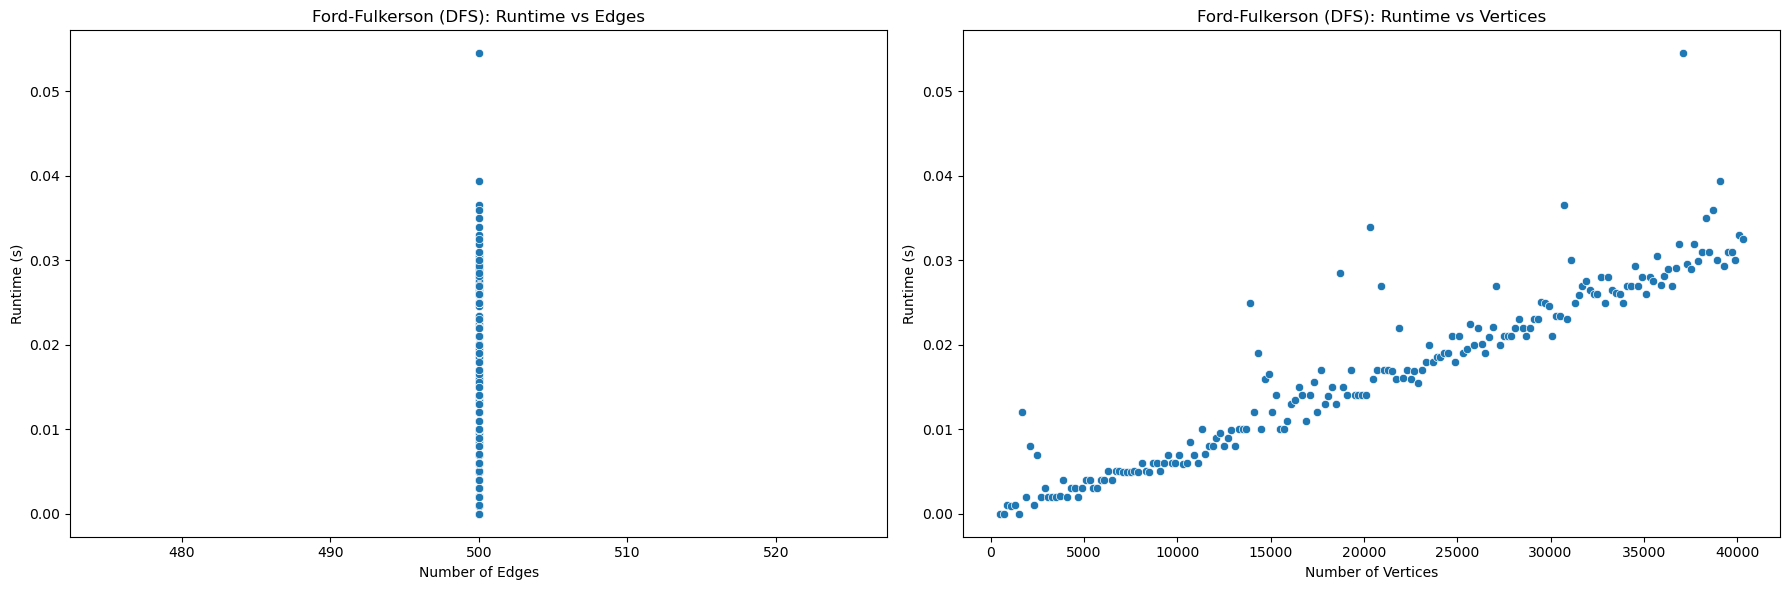

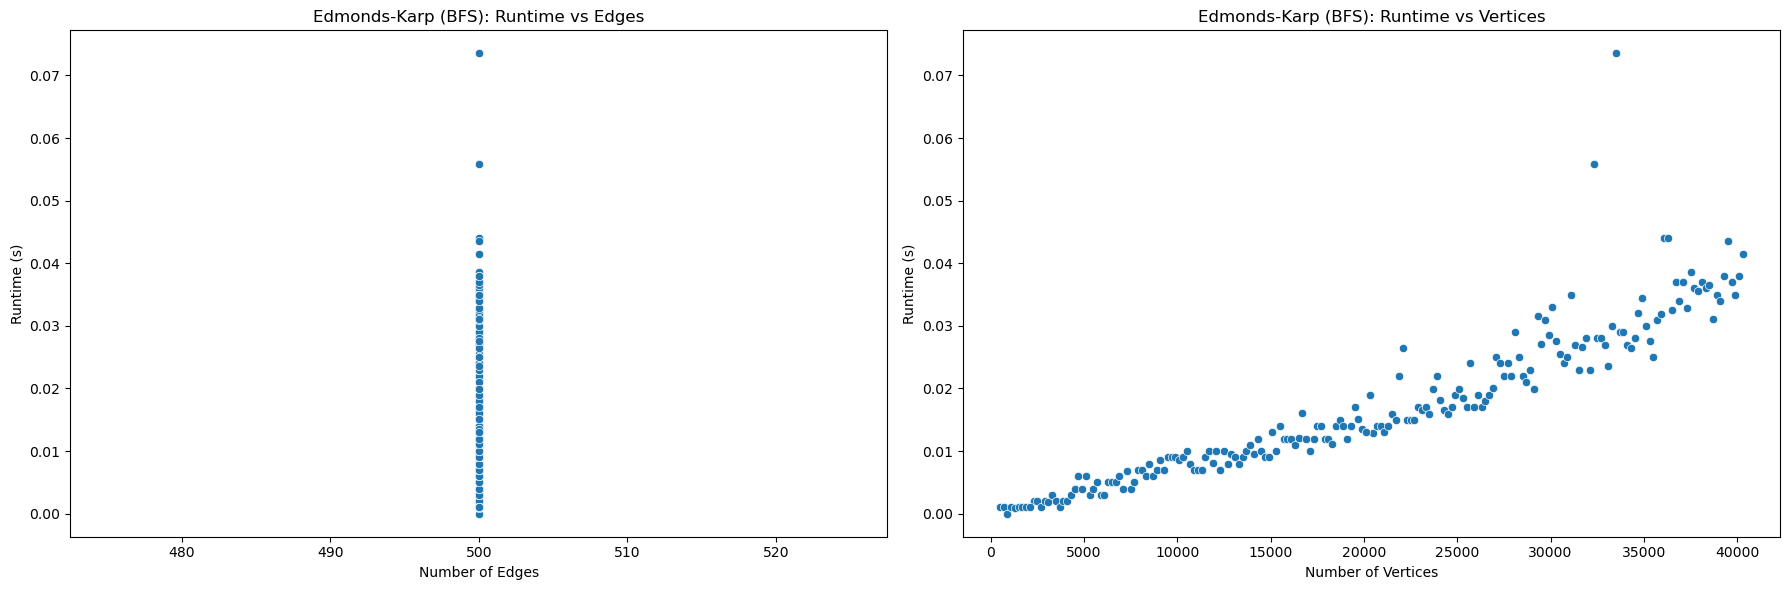

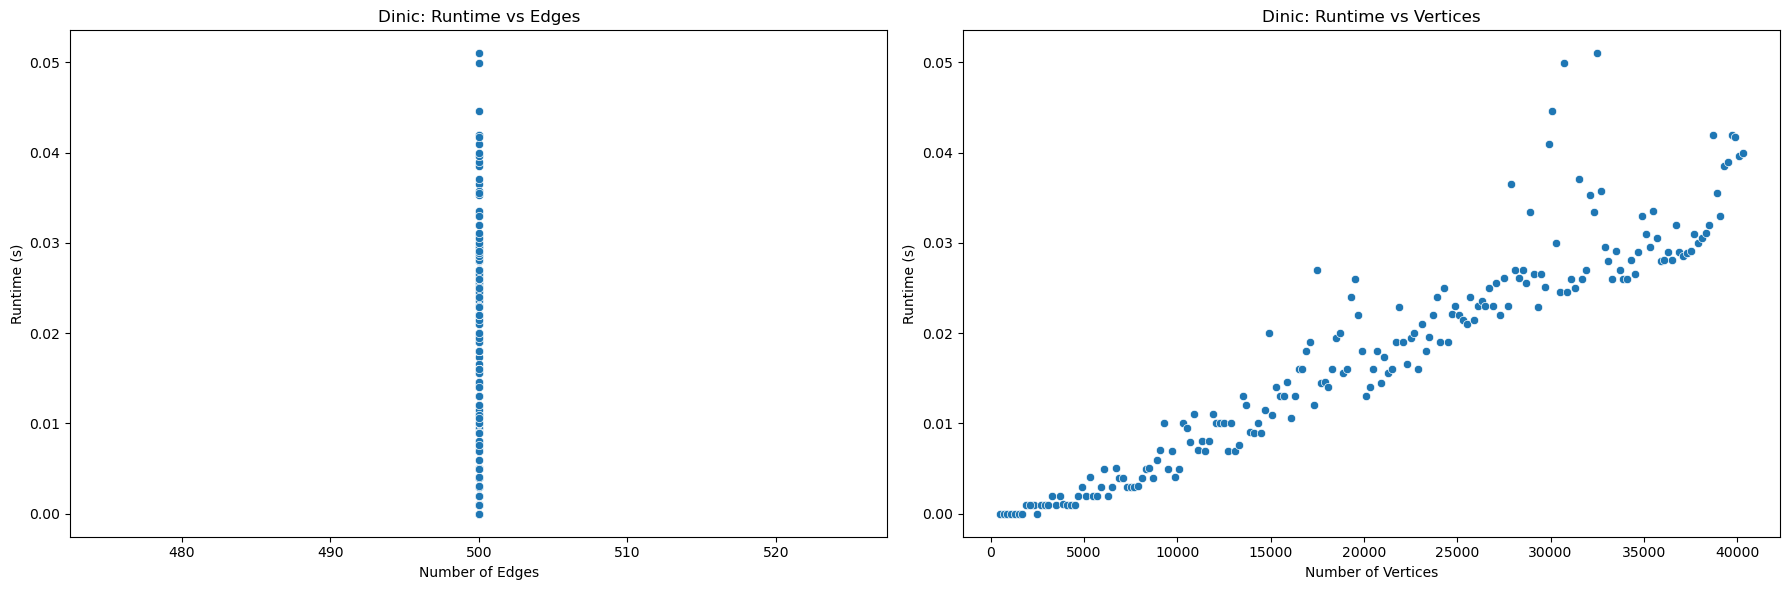

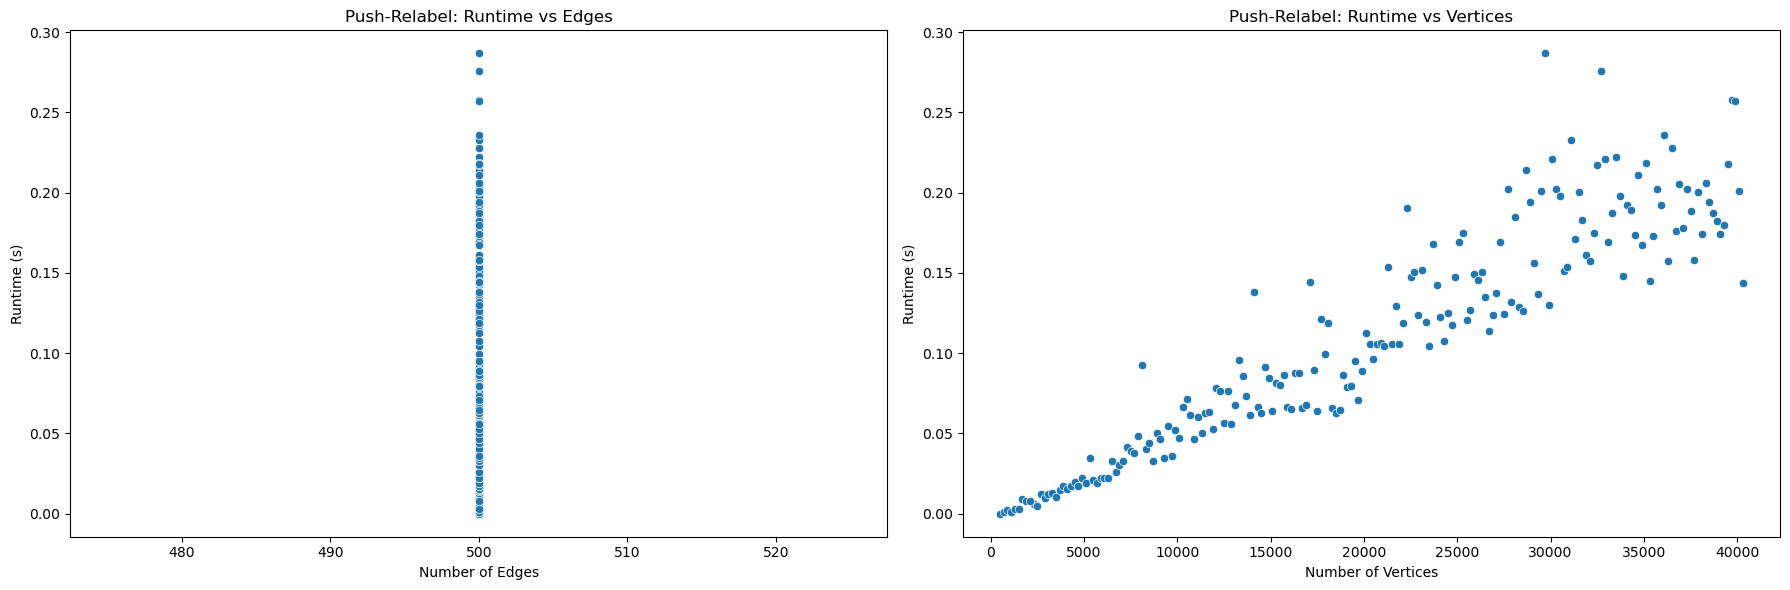

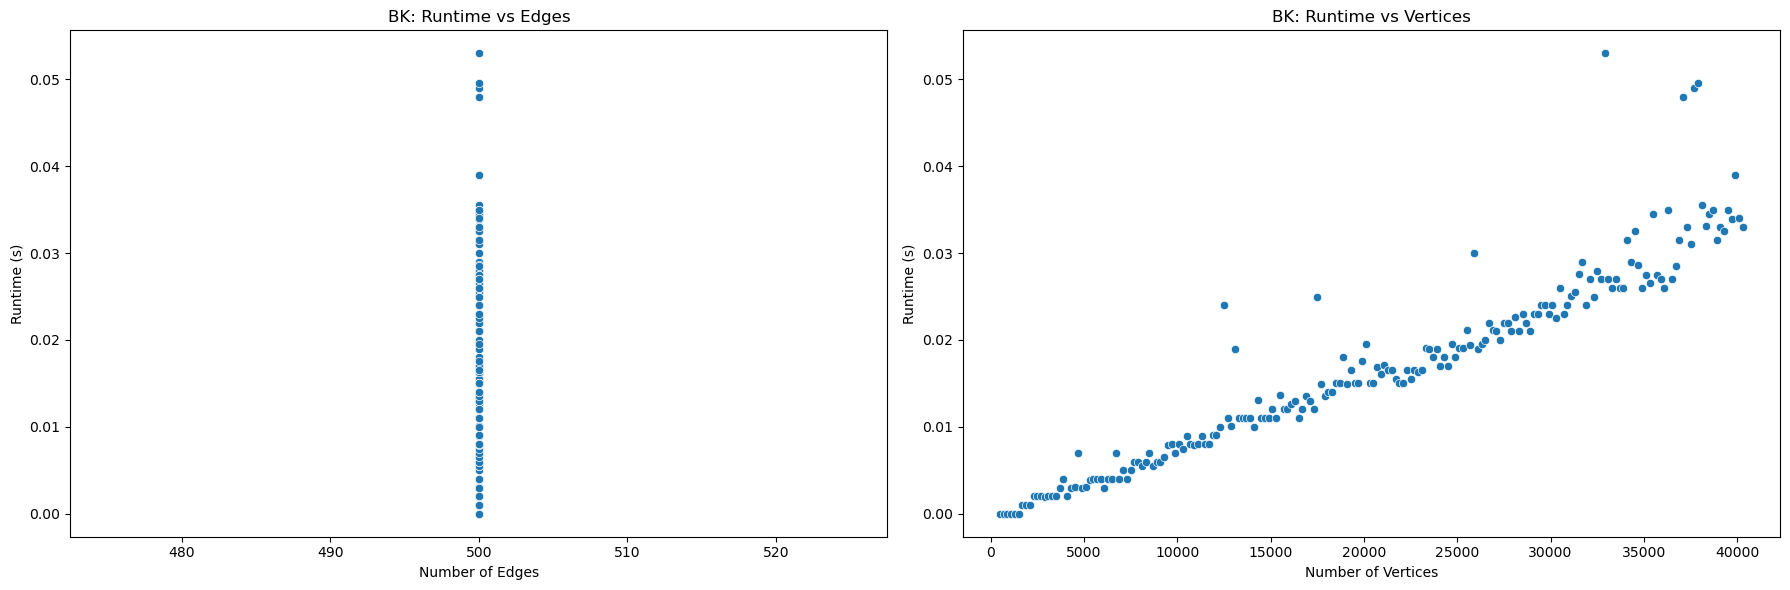

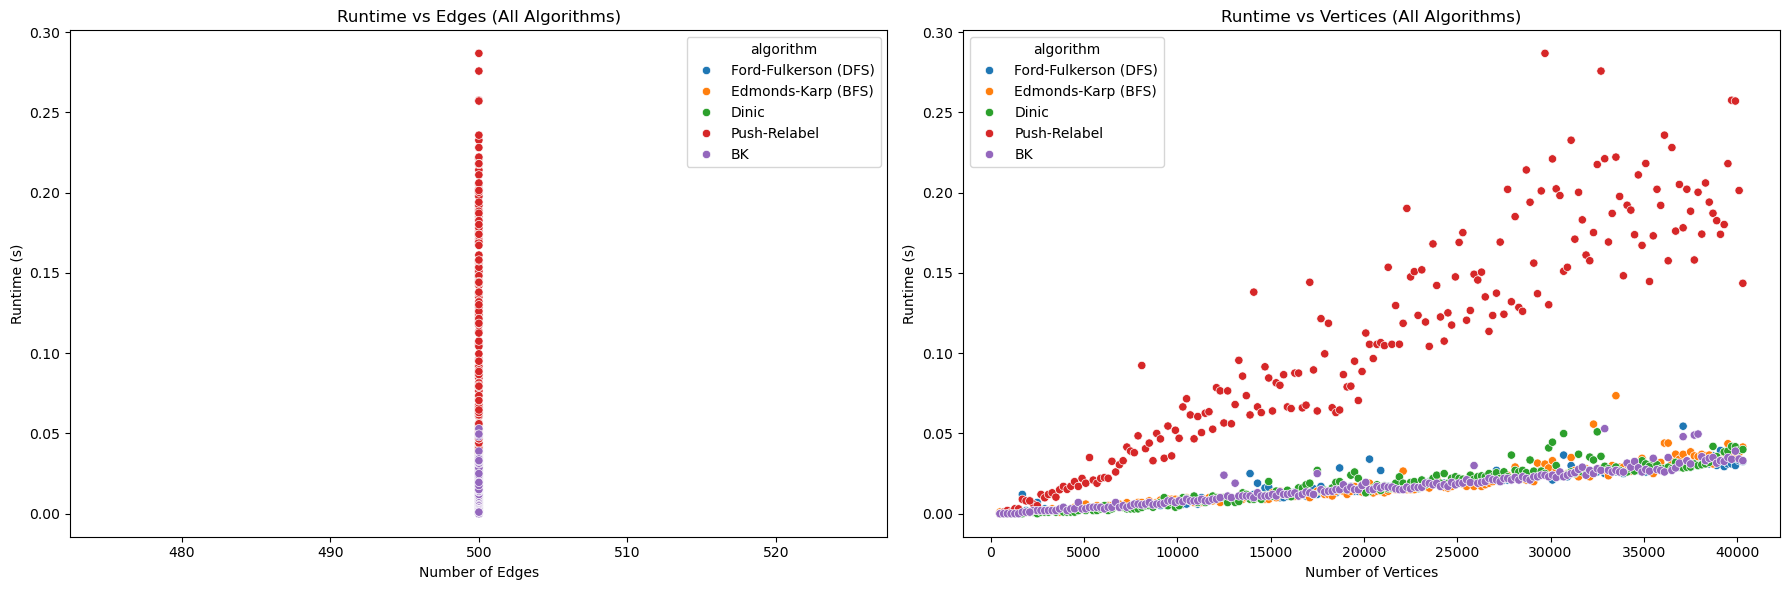

In [132]:
%matplotlib inline
# Plot runtime vs edges and runtime vs vertices for each algorithm separately (except BK)
for algo_name in results_df['algorithm'].unique():
    df_algo = results_df[results_df['algorithm'] == algo_name]
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    sns.scatterplot(data=df_algo, x="edges", y="runtime", ax=axes[0])
    axes[0].set_title(f"{algo_name}: Runtime vs Edges")
    axes[0].set_xlabel("Number of Edges")
    axes[0].set_ylabel("Runtime (s)")
    
    sns.scatterplot(data=df_algo, x="vertices", y="runtime", ax=axes[1])
    axes[1].set_title(f"{algo_name}: Runtime vs Vertices")
    axes[1].set_xlabel("Number of Vertices")
    axes[1].set_ylabel("Runtime (s)")
    plt.tight_layout()
    plt.show()

# Plot all algorithms together (except BK)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.scatterplot(data=results_df, x="edges", y="runtime", hue="algorithm", ax=axes[0])
axes[0].set_title("Runtime vs Edges (All Algorithms)")
axes[0].set_xlabel("Number of Edges")
axes[0].set_ylabel("Runtime (s)")

sns.scatterplot(data=results_df, x="vertices", y="runtime", hue="algorithm", ax=axes[1])
axes[1].set_title("Runtime vs Vertices (All Algorithms)")
axes[1].set_xlabel("Number of Vertices")
axes[1].set_ylabel("Runtime (s)")
plt.tight_layout()
plt.show()

In [133]:
bk_mod = import_from_path('bk', './Boykov-Kolmogorov/simplified.py')

In [134]:
# Run BK algorithm on its own grid graphs and collect timing data
bk_sizes = [i for i in range(4, 257, 4)]
bk_times = []
bk_vertices = []
bk_edges = []

for S in bk_sizes:
    H = W = S
    g = bk_mod.build_grid_graph(H, W)
    V = 2 + H * W
    E = sum(len(g.adj[u]) for u in range(g.n))
    bk_vertices.append(V)
    bk_edges.append(E)
    start = time.time()
    g.max_flow(0, 1)
    end = time.time()
    bk_times.append(end - start)

bk_df = pd.DataFrame({
    "algorithm": "BK",
    "vertices": bk_vertices,
    "edges": bk_edges,
    "runtime": bk_times
})


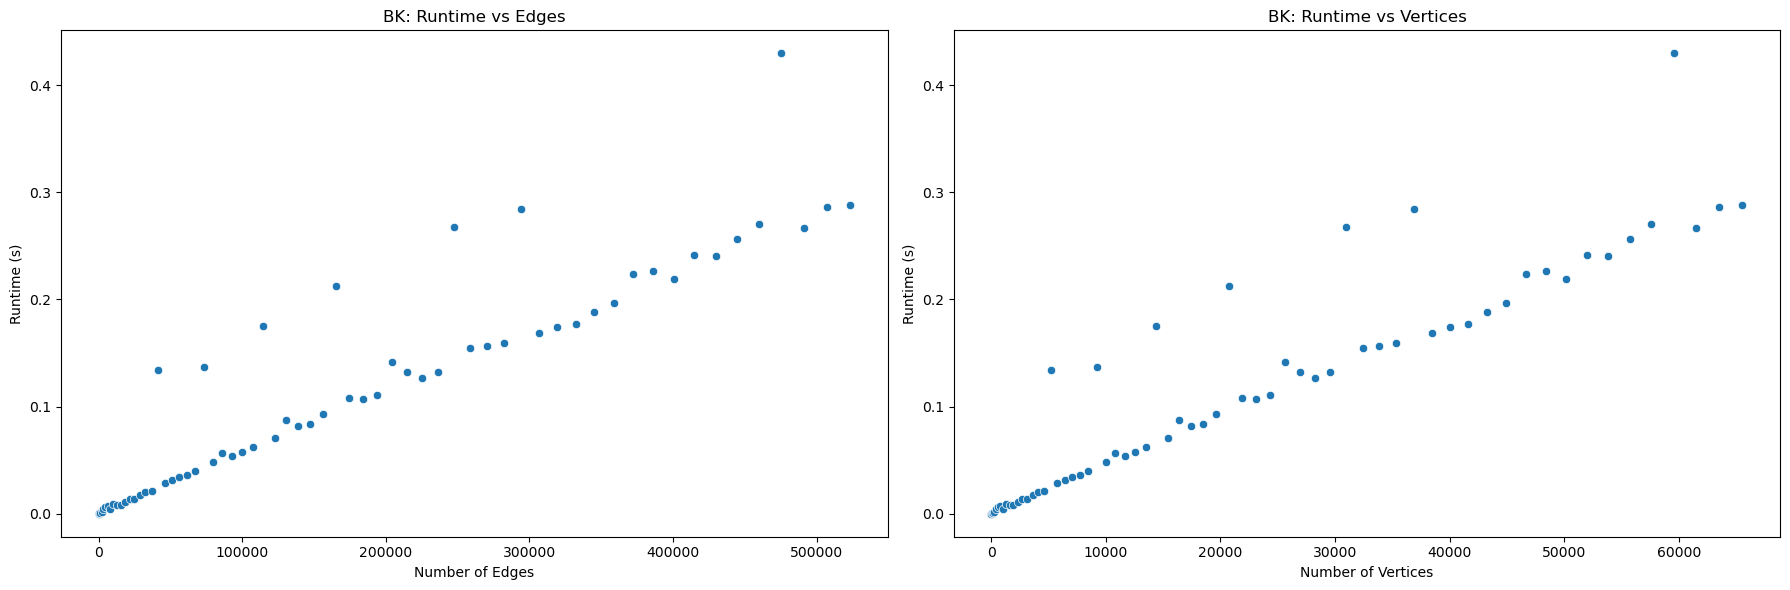

In [135]:
%matplotlib inline
# Plot BK results separately
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.scatterplot(data=bk_df, x="edges", y="runtime", ax=axes[0])
axes[0].set_title("BK: Runtime vs Edges")
axes[0].set_xlabel("Number of Edges")
axes[0].set_ylabel("Runtime (s)")

sns.scatterplot(data=bk_df, x="vertices", y="runtime", ax=axes[1])
axes[1].set_title("BK: Runtime vs Vertices")
axes[1].set_xlabel("Number of Vertices")
axes[1].set_ylabel("Runtime (s)")
plt.tight_layout()
plt.show()

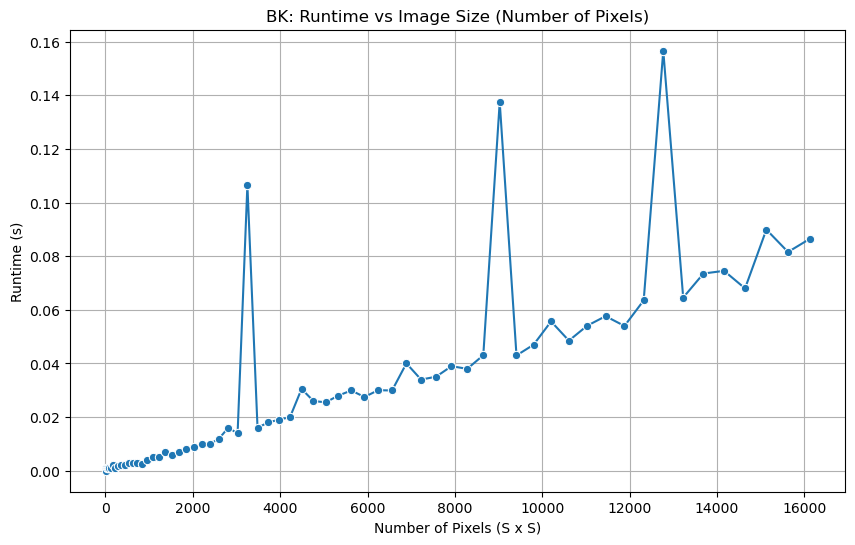

In [136]:
# --- BK: Runtime vs Image Size Experiment ---
import numpy as np
from PIL import Image

bk_img_sizes = [i for i in range(1, 129, 2)]
bk_img_times = []
bk_img_pixels = []

for S in bk_img_sizes:
    # Create a synthetic binary image (random foreground/background)
    img = (np.random.rand(S, S) > 0.5).astype(np.uint8) * 255
    # Convert to PIL Image if needed (BK may expect numpy array or PIL Image)
    # For this experiment, we assume BK can take a numpy array
    # If your BK implementation expects a file, save and reload as needed
    try:
        g = bk_mod.build_grid_graph(S, S)  # Use the same grid graph builder for image size SxS
        start = time.time()
        g.max_flow(0, 1)
        end = time.time()
        runtime = end - start
    except Exception as e:
        runtime = np.nan
    bk_img_times.append(runtime)
    bk_img_pixels.append(S * S)

bk_img_df = pd.DataFrame({
    "image_size": bk_img_sizes,
    "num_pixels": bk_img_pixels,
    "runtime": bk_img_times
})

# Plot runtime vs image size (pixels)
plt.figure(figsize=(10, 6))
sns.lineplot(data=bk_img_df, x="num_pixels", y="runtime", marker="o")
plt.title("BK: Runtime vs Image Size (Number of Pixels)")
plt.xlabel("Number of Pixels (S x S)")
plt.ylabel("Runtime (s)")
plt.grid(True)
plt.show()

## Summary and Interpretation

- The above plots show the empirical runtime of Dinic's, Push-Relabel, and Boykov-Kolmogorov (BK) algorithms as a function of the number of edges and vertices.
- Each algorithm's performance may vary depending on the graph structure and size.
- BK is run on grid graphs, while the others are run on a variety of graphs from the project datasets.
- For a fair comparison, ensure the graph types and sizes are as similar as possible.
- Further analysis can include memory usage, solution quality, and scalability on larger graphs.

---

*You can extend this notebook by adding Edmonds-Karp and more detailed analysis as needed.*